In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd

In [2]:
def get_max_length(smiles: str) -> float:
    mol = Chem.MolFromSmiles(smiles)
    # Add hydrogen atoms to the molecule 
    mol = Chem.AddHs(mol)
    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())

    # Optimize the geometry
    AllChem.UFFOptimizeMolecule(mol)

    # Calculate the maximum distance between any two atoms
    coords = mol.GetConformer().GetPositions()

    return np.max([np.linalg.norm(coords[i]- coords[j]) for i in range(len(coords)) for j in range(i+1, len(coords))])


In [3]:
# load predictions for QMOF
tp = pd.read_csv("T_P_qmof.csv", index_col=0)
gm = pd.read_csv("ges_mol_qmof.csv", index_col=0)
no = pd.read_csv("no_pred_qmof.csv", index_col=0)

In [4]:
len(tp),len(gm),len(no)

(1646, 539, 5278)

In [5]:
len(tp)+len(gm)+len(no)

7463

In [6]:
# load linker data for QMOF
data = pd.read_csv("../preprocessing/qmof/data/qmof_property_cell.csv", index_col=1)

In [ ]:
tp_lengths = pd.DataFrame(columns=["max_len"])
bed_count = 0
for name in tp.index:
    smi = data["smilesLinkers"].loc[name]
    ss = smi.split(",") # split 'linker1,linker2' to ['linker1', 'linker2']
    curr_lengths = []

    for s in ss:
        try:
            curr_len = get_max_length(s)
            curr_lengths.append(curr_len)
        except Exception:
            bed_count += 1
            
            print(s)
        
    if curr_lengths:
        tp_lengths.loc[name] = [max(curr_lengths)]

In [8]:
print(f"Number of errors: {bed_count}")

Number of errors: 5


In [9]:
len(tp_lengths)

1644

In [ ]:
gm_lengths = pd.DataFrame(columns=["max_len"])
bed_count = 0
for name in gm.index:
    smi = data["smilesLinkers"].loc[name]
    ss = smi.split(",")
    curr_lengths = []

    for s in ss:
        try:
            curr_len = get_max_length(s)
            curr_lengths.append(curr_len)
        except Exception:
            bed_count += 1
            
            print(s)
        
    if curr_lengths:
        gm_lengths.loc[name] = [max(curr_lengths)]


In [11]:
print(f"Number of errors: {bed_count}")

Number of errors: 4


In [12]:
len(gm_lengths)

539

In [ ]:
no_lengths = pd.DataFrame(columns=["max_len"])
bed_count = 0
for name in no.index:
    smi = data["smilesLinkers"].loc[name]
    ss = smi.split(",")
    curr_lengths = []

    for s in ss:
        try:
            curr_len = get_max_length(s)
            curr_lengths.append(curr_len)
        except Exception:
            bed_count += 1
            
            print(s)
        
    if curr_lengths:
        no_lengths.loc[name] = [max(curr_lengths)]


In [14]:
print(f"Number of errors: {bed_count}")

Number of errors: 434


In [15]:
len(no_lengths)

5061

In [16]:
# save max lengths for optimized geometry
no_lengths.to_csv("linker_lengths/no_lengths_opt.csv")
tp_lengths.to_csv("linker_lengths/tp_lengths_opt.csv")
gm_lengths.to_csv("linker_lengths/gm_lengths_opt.csv")

In [17]:
no_lengths = pd.read_csv("linker_lengths/no_lengths_opt.csv", index_col=0)
tp_lengths = pd.read_csv("linker_lengths/tp_lengths_opt.csv", index_col=0)
gm_lengths = pd.read_csv("linker_lengths/gm_lengths_opt.csv", index_col=0)

In [18]:
len(no_lengths),len(tp_lengths),len(gm_lengths)

(5061, 1644, 539)

In [19]:
len(no_lengths) + len(tp_lengths) + len(gm_lengths)

7244

In [20]:
import json

mapping_ = json.load(open("../names_mapping.json"))

In [21]:
mofid_data = pd.read_csv("../preprocessing/mofid/mofid_data_.csv", index_col=0)

target = pd.read_csv("../database/main.csv", sep=";", index_col=1)


In [22]:
linkers = pd.DataFrame([[smi.strip('"')[1:-1].replace("'", "").split(", ")] for smi in mofid_data['linker'].values], index=mofid_data.index, columns=["linker"])

In [ ]:
main_lengths = pd.DataFrame(columns=["max_length", "target"])
bad_count = 0
for name in target.index:
    if name in mapping_ and mapping_[name][:-4] in linkers.index:
        ss = linkers["linker"].loc[mapping_[name][:-4]]
        curr_lengths = []

        for s in ss:
            try:
                curr_len = get_max_length(s)
                curr_lengths.append(curr_len)
            except Exception:
                bad_count += 1
                print(s)
            
        if curr_lengths:
            ans = 0 if target.loc[name]["Stimuli"].find("T") != -1 or target.loc[name]["Stimuli"].find("pressure") != -1 or target.loc[name]["Stimuli"].find("Pressure") != -1 else 1
            main_lengths.loc[mapping_[name][:-4]] = [max(curr_lengths), ans]

In [24]:
def get_statistics(distribution):
    res = {}
    res["Mean"] = np.mean(distribution)
    res["Std"] = np.std(distribution)
    print(f"\tMean (+- std): {res['Mean']:.2f} (+- {res['Std']:.2f}) Å")
    count, edge = np.histogram(distribution, bins=20)
    i = np.argmax(count)
    mode_bin = [edge[i], edge[i+1]]
    res["Mode"] = np.mean(mode_bin)
    res["Dev"] = (mode_bin[1] - mode_bin[0])/2
    print(f"\tMode: {res['Mode']:.2f} (+- {res['Dev']:.2f}) Å")

    res["Median"] = np.median(distribution)
    print(f"\tMedian: {res['Median']:.2f} Å")

    res["Q1"], res["Q2"], res["Q3"] = np.percentile(distribution, [25, 50, 75])

    print(f"\tQuantiles:\n\t25% - {res['Q1']:.2f} Å\n\t50% - {res['Q2']:.2f} Å\n\t75% - {res['Q3']:.2f} Å")
    return res


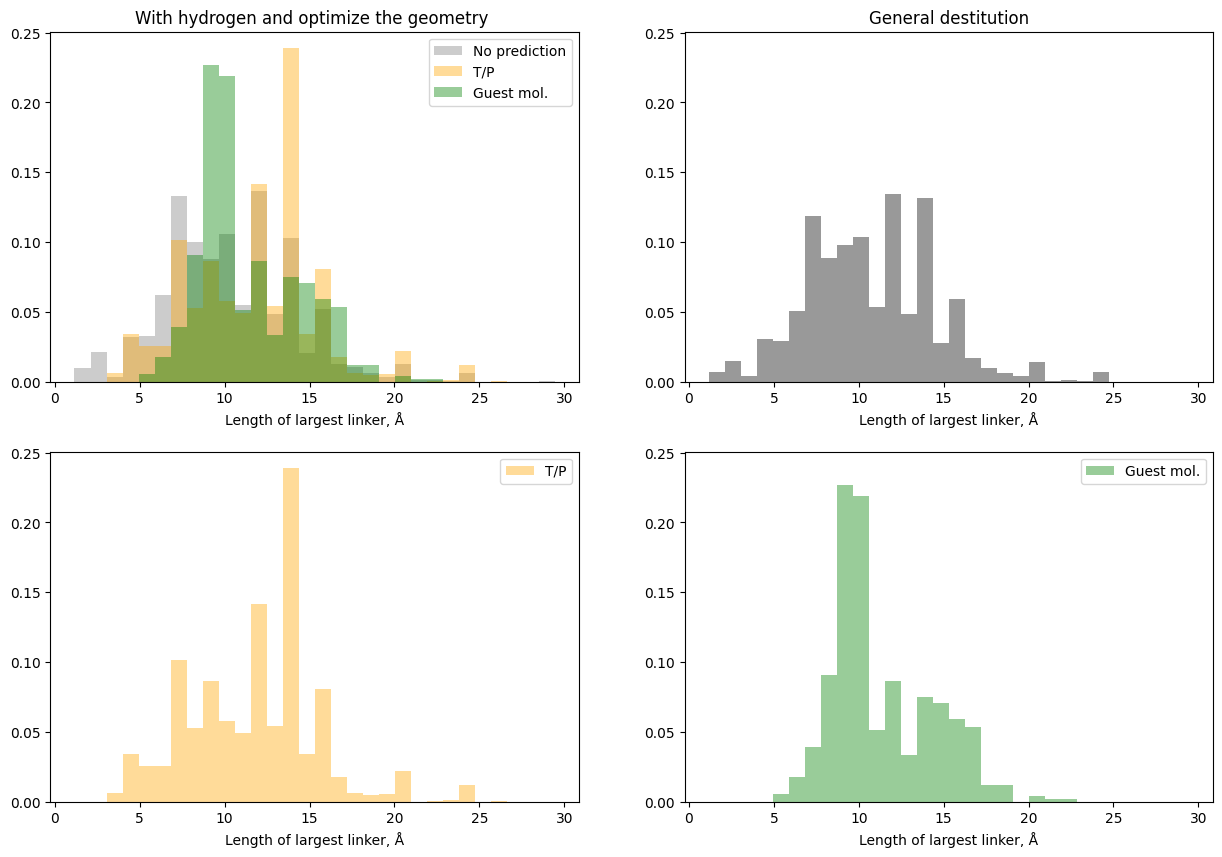

In [25]:
import matplotlib.pyplot as plt


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

x1, bins, patch = ax1.hist(no_lengths.values[:, 0], density=True, bins = 30, alpha=0.4, label="No prediction", color='gray')
ax1.hist(tp_lengths.values[:, 0],bins = bins, density=True, alpha=0.4, label="T/P", color='orange')
ax1.hist(gm_lengths.values[:, 0],bins = bins, density=True, alpha=0.4, label="Guest mol.", color='green')
ax1.set_title("With hydrogen and optimize the geometry ")
ax1.set_xlabel("Length of largest linker, Å")
ax1.legend()

ax2.hist(np.concatenate([no_lengths.values[:, 0], tp_lengths.values[:, 0], gm_lengths.values[:, 0]]),bins = bins, density=True, alpha=0.4, color='black')
ax2.set_title("General destitution")
ax2.set_xlabel("Length of largest linker, Å")
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())


ax3.hist(tp_lengths.values[:, 0], label="T/P",bins = bins, density=True, alpha=0.4, color='orange')
# ax3.set_title("T/P")
ax3.set_xlabel("Length of largest linker, Å")
ax3.set_ylim(ax1.get_ylim())
ax3.set_xlim(ax1.get_xlim())
ax3.legend()


ax4.hist(gm_lengths.values[:, 0], label="Guest mol.",bins = bins, density=True, alpha=0.4, color='green')
# ax4.set_title("guest mol.")
ax4.set_xlabel("Length of largest linker, Å")
ax4.set_ylim(ax1.get_ylim())
ax4.set_xlim(ax1.get_xlim())
ax4.legend()


In [26]:
stats = pd.DataFrame(columns=["Mean", "Std", "Mode", "Dev", "Median", "Q1", "Q2", "Q3"])

print("T/P QMOF")
stats.loc["T/P QMOF"] = get_statistics(tp_lengths.values[:, 0])

print("Guest mol. QMOF")
stats.loc["Guest mol. QMOF"] = get_statistics(gm_lengths.values[:, 0])

print("No prediction QMOF")
stats.loc["No prediction QMOF"] = get_statistics(no_lengths.values[:, 0])

print("General distribution QMOF")
stats.loc["General distribution QMOF"] = get_statistics(np.concatenate([no_lengths.values[:, 0], tp_lengths.values[:, 0], gm_lengths.values[:, 0]]))

T/P QMOF
	Mean (+- std): 11.80 (+- 3.83) Å
	Mode: 14.22 (+- 0.58) Å
	Median: 11.96 Å
	Quantiles:
	25% - 9.09 Å
	50% - 11.96 Å
	75% - 14.21 Å
Guest mol. QMOF
	Mean (+- std): 11.38 (+- 3.16) Å
	Mode: 8.91 (+- 0.71) Å
	Median: 10.31 Å
	Quantiles:
	25% - 9.20 Å
	50% - 10.31 Å
	75% - 13.84 Å
No prediction QMOF
	Mean (+- std): 10.36 (+- 3.87) Å
	Mode: 7.52 (+- 0.71) Å
	Median: 9.98 Å
	Quantiles:
	25% - 7.58 Å
	50% - 9.98 Å
	75% - 12.53 Å
General distribution QMOF
	Mean (+- std): 10.76 (+- 3.86) Å
	Mode: 11.79 (+- 0.82) Å
	Median: 10.45 Å
	Quantiles:
	25% - 7.90 Å
	50% - 10.45 Å
	75% - 13.64 Å


(-0.25716440536024576, 30.857748809079872)

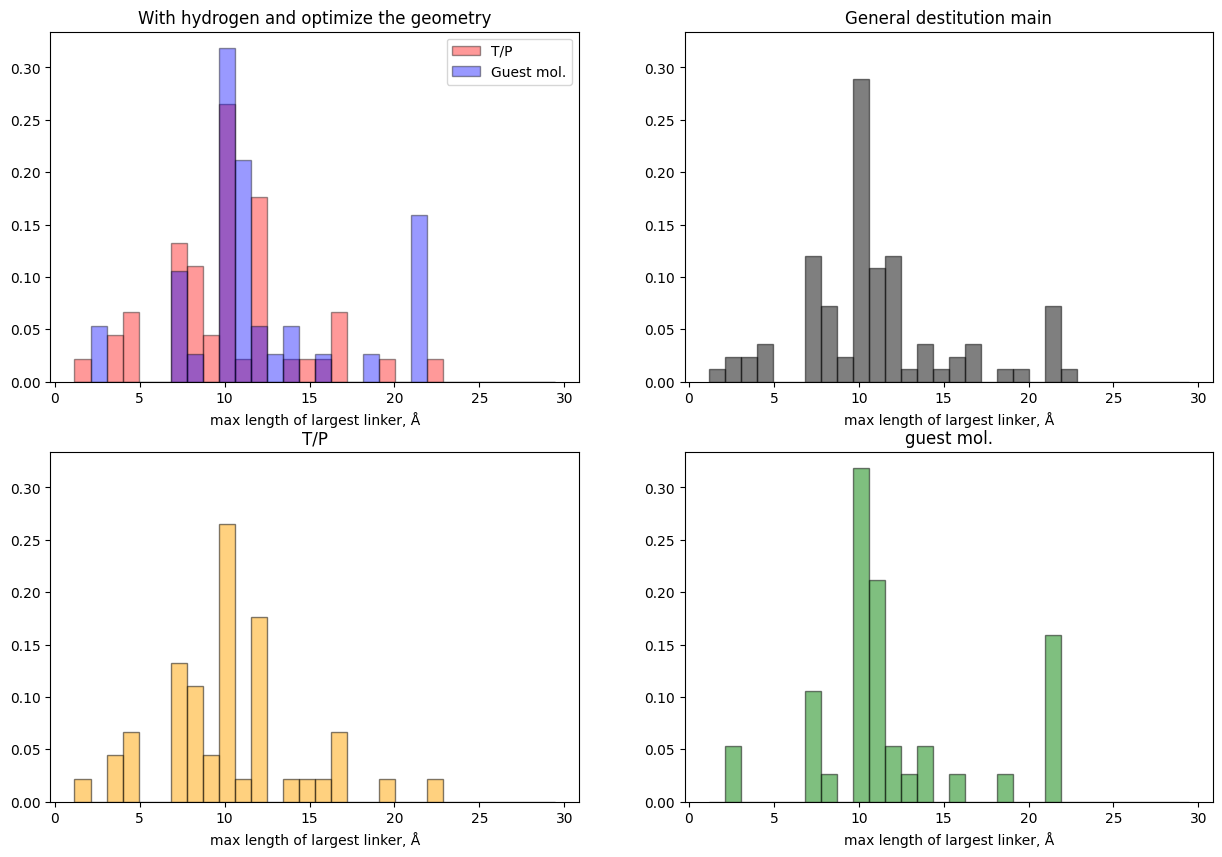

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# x1, bins, patch = ax1.hist(main_lengths.max_length.values, density=True, bins = 30, alpha=0.4, label="no prediction", color='gray')
ax1.hist(main_lengths.max_length.loc[main_lengths.target == 1].values, bins = bins, density=True, alpha=0.4, label="T/P", color='red', edgecolor="black", stacked=True)
ax1.hist(main_lengths.max_length.loc[main_lengths.target == 0].values,bins = bins, density=True, alpha=0.4, label="Guest mol.", color='blue', edgecolor="black", stacked=True)
ax1.set_title("With hydrogen and optimize the geometry")
ax1.set_xlabel("max length of largest linker, Å")
ax1.legend()

ax2.hist(main_lengths.max_length.values,bins = bins, density=True, alpha=0.5, color='black', edgecolor="black", stacked=True)
ax2.set_title("General destitution main")
ax2.set_xlabel("max length of largest linker, Å")
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())


ax3.hist(main_lengths.max_length.loc[main_lengths.target == 1],bins = bins, density=True, alpha=0.5, color='orange', edgecolor="black")
ax3.set_title("T/P")
ax3.set_xlabel("max length of largest linker, Å")
ax3.set_ylim(ax1.get_ylim())
ax3.set_xlim(ax1.get_xlim())


ax4.hist(main_lengths.max_length.loc[main_lengths.target == 0],bins = bins, density=True, alpha=0.5, color='green', edgecolor="black")
ax4.set_title("guest mol.")
ax4.set_xlabel("max length of largest linker, Å")
ax4.set_ylim(ax1.get_ylim())
ax4.set_xlim(ax1.get_xlim())

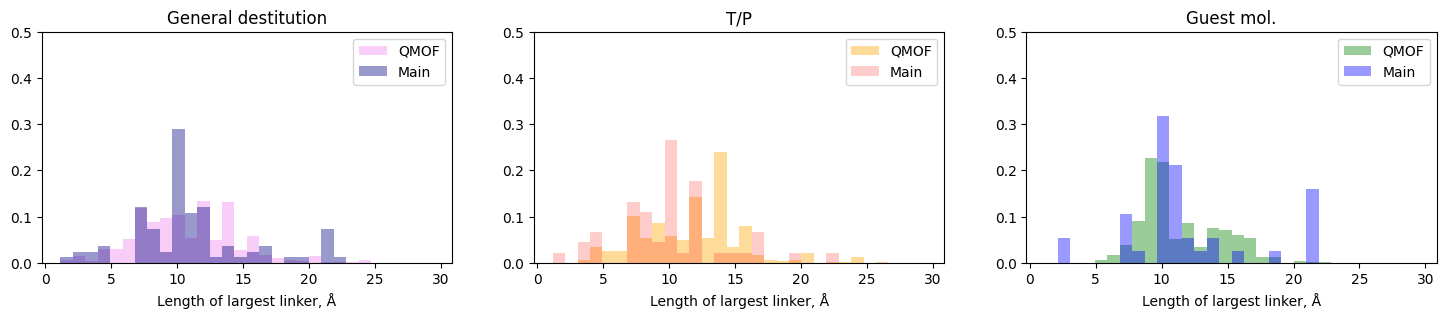

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3))


ax1.hist(np.concatenate([no_lengths.values[:, 0], tp_lengths.values[:, 0], gm_lengths.values[:, 0]]),bins = bins, density=True, alpha=0.4, color='violet', label="QMOF")

ax1.hist(main_lengths.max_length.values,bins = bins, density=True, alpha=0.4, color='navy', label="Main")

ax1.set_title("General destitution")
ax1.set_xlabel("Length of largest linker, Å")
ax1.set_ylim(0, 0.5)
# ax1.set_xlim()

ax1.legend()


ax2.hist(tp_lengths.values[:, 0],bins = bins, density=True, alpha=0.4, color='orange', label="QMOF")
ax2.hist(main_lengths.max_length.loc[main_lengths.target == 1],bins = bins, density=True, alpha=0.2, color='red', label="Main")

ax2.set_title("T/P")
ax2.set_xlabel("Length of largest linker, Å")
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlim(ax1.get_xlim())
ax2.legend()

ax3.hist(gm_lengths.values[:, 0],bins = bins, density=True, alpha=0.4, color='green', label="QMOF")
ax3.hist(main_lengths.max_length.loc[main_lengths.target == 0],bins = bins, density=True, alpha=0.4, color='blue', label="Main")
ax3.set_title("Guest mol.")
ax3.set_xlabel("Length of largest linker, Å")
ax3.set_ylim(ax1.get_ylim())
ax3.set_xlim(ax1.get_xlim())
ax3.legend()


In [29]:
print("T/P Main")
stats.loc["T/P Main"] = get_statistics(main_lengths.max_length.loc[main_lengths.target == 1])

print("Guest mol. Main")
stats.loc["Guest mol. Main"] = get_statistics(main_lengths.max_length.loc[main_lengths.target == 0])

print("General distribution Main")
stats.loc["General distribution Main"] = get_statistics(main_lengths.max_length)

T/P Main
	Mean (+- std): 10.21 (+- 4.11) Å
	Mode: 10.26 (+- 0.53) Å
	Median: 9.98 Å
	Quantiles:
	25% - 7.84 Å
	50% - 9.98 Å
	75% - 11.70 Å
Guest mol. Main
	Mean (+- std): 12.03 (+- 4.93) Å
	Mode: 10.51 (+- 0.49) Å
	Median: 10.67 Å
	Quantiles:
	25% - 9.95 Å
	50% - 10.67 Å
	75% - 13.56 Å
General distribution Main
	Mean (+- std): 11.04 (+- 4.59) Å
	Mode: 10.26 (+- 0.53) Å
	Median: 10.43 Å
	Quantiles:
	25% - 8.13 Å
	50% - 10.43 Å
	75% - 11.94 Å


In [30]:
stats

,Mean,Std,Mode,Dev,Median,Q1,Q2,Q3
T/P QMOF,11.803794,3.826334,14.217046,0.577395,11.961722,9.090310,11.961722,14.206862
Guest mol. QMOF,11.378259,3.164411,8.913525,0.713067,10.305302,9.196140,10.305302,13.839901
No prediction QMOF,10.358283,3.870961,7.521564,0.707157,9.976370,7.579703,9.976370,12.534367
General distribution QMOF,10.762229,3.863284,11.789106,0.817843,10.447452,7.901227,10.447452,13.640369
T/P Main,10.206517,4.114919,10.257105,0.531626,9.978615,7.836344,9.978615,11.697124
Guest mol. Main,12.033858,4.930169,10.508056,0.485841,10.674178,9.951690,10.674178,13.562813
General distribution Main,11.037127,4.594809,10.257105,0.531626,10.434720,8.132855,10.434720,11.944380
